In [1]:
import random
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import torch,torchvision
from torch.nn import *
from tqdm import tqdm
import cv2
from torch.optim import *
# Preproccessing
from sklearn.preprocessing import (
    StandardScaler,
    RobustScaler,
    MinMaxScaler,
    MaxAbsScaler,
    OneHotEncoder,
    Normalizer,
    Binarizer
)
# Decomposition
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
# Feature Selection
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel
# Model Eval
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error
# Other
import pickle
import wandb

PROJECT_NAME = 'E-Commerce-Retail-Sales-Series'
device = 'cuda:0'
np.random.seed(21)
random.seed(21)
torch.manual_seed(21)

In [2]:
data = pd.read_csv('./data/ECOMNSA.csv')

<AxesSubplot:>

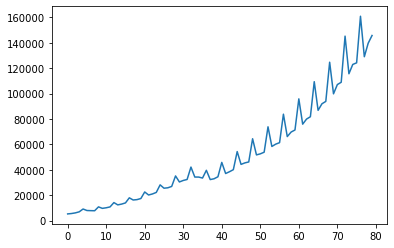

In [3]:
data['value'].plot()

In [4]:
data = data['value']

In [5]:
data.to_csv('./cleaned-data.csv',index=False)

In [6]:
data = pd.read_csv('./cleaned-data.csv')

In [7]:
data = data['value'].tolist()

In [8]:
data = torch.from_numpy(np.array(data)).to(device).float().view(1,-1)

In [9]:
torch.save(data,'./data.pt')
torch.save(data,'./data.pth')

In [10]:
data_input = data[:1,:-1].to(device).float()
data_target = data[:1,1:].to(device).float()

In [11]:
torch.save(data_input,'data_input.pt')
torch.save(data_input,'data_input.pth')

In [12]:
torch.save(data_target,'data_target.pt')
torch.save(data_target,'data_target.pth')

In [13]:
class Model(Module):
    def __init__(self):
        super().__init__()
        self.hidden = 512
        self.lstm1 = LSTMCell(1,self.hidden)
        self.lstm2 = LSTMCell(self.hidden,self.hidden)
        self.linear = Linear(self.hidden,1)
    
    def forward(self,X,future=0):
        preds = []
        batch_size = X.shape[0]
        h_t1 = torch.zeros(batch_size,self.hidden).to(device)
        c_t1 = torch.zeros(batch_size,self.hidden).to(device)
        h_t2 = torch.zeros(batch_size,self.hidden).to(device)
        c_t2 = torch.zeros(batch_size,self.hidden).to(device)
        for X_bacth in X.split(1,dim=1):
            X_bacth = X_bacth.to(device)
            h_t1,c_t1 = self.lstm1(X_bacth,(h_t1,c_t1))
            h_t1 = h_t1.to(device)
            c_t1 = c_t1.to(device)
            h_t2,c_t2 = self.lstm2(h_t1,(h_t2,c_t2))
            h_t2 = h_t2.to(device)
            c_t2 = c_t2.to(device)
            pred = self.linear(h_t2)
            preds.append(pred)
        for _ in range(future):
            h_t1,c_t1 = self.lstm1(X_bacth,(h_t1,c_t1))
            h_t1 = h_t1.to(device)
            c_t1 = c_t1.to(device)
            h_t2,c_t2 = self.lstm2(h_t1,(h_t2,c_t2))
            h_t2 = h_t2.to(device)
            c_t2 = c_t2.to(device)
            pred = self.linear(h_t2)
            preds.append(pred)
        preds = torch.cat(preds,dim=1)
        return preds

In [14]:
model = Model().to(device)
criterion = MSELoss()
optimizer = LBFGS(model.parameters(),lr=0.8)
epochs = 100

In [15]:
torch.save(model,'custom-model.pt')
torch.save(model,'custom-model.pth')

In [16]:
torch.save(model.state_dict(),'custom-model-sd.pt')
torch.save(model.state_dict(),'custom-model-sd.pth')

In [17]:
wandb.init(project=PROJECT_NAME,name='baseline')
wandb.watch(model)
for _ in tqdm(range(epochs)):
    def closure():
        optimizer.zero_grad()
        preds = model(data_input)
        loss = criterion(preds,data_target)
        loss.backward()
        wandb.log({'Loss':loss.item()})
        return loss
    optimizer.step(closure)
    model.eval()
    with torch.no_grad():
        future = 100
        preds = model(data_input,future)
        loss = criterion(preds[:,:-future],data_target)
        wandb.log({'Val Loss':loss.item()})
        preds = preds[0].view(-1).cpu().detach().numpy()
        n = data_input.shape[1]
        plt.figure(figsize=(12,6))
        plt.plot(np.arange(n),data_target.view(-1).cpu().detach().numpy())
        plt.plot(np.arange(n,n+future),preds[n:])
        plt.savefig('./img.png')
        plt.close()
        wandb.log({'Img':wandb.Image(cv2.imread('./img.png'))})
wandb.finish()

wandb: Currently logged in as: ranuga-d (use `wandb login --relogin` to force relogin)


 50%|█████████████████████                     | 50/100 [01:28<01:28,  1.77s/it]


RuntimeError: max must be larger than min

In [18]:
torch.save(model,'model.pt')
torch.save(model,'model.pth')

In [19]:
torch.save(model.state_dict(),'model-sd.pt')
torch.save(model.state_dict(),'model-sd.pth')